In [127]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

In [128]:
train = pd.read_csv("./train.csv", encoding = 'gb18030')
test = pd.read_csv("./test.csv", encoding = 'gb18030')

In [129]:
#train.corr()['score']

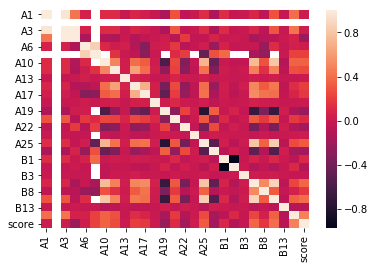

In [130]:
rel = train.corr()
sns.heatmap(rel)
plt.show()

In [131]:
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [132]:
# 删除某一类别占比超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col,rate)

# 删除异常值
train = train[(train['score'] > 0.87) & (train['B14'] > 40) & (train['A6'] < 50)]
        
train = train[good_cols]
good_cols.remove('score')
test  = test[good_cols]

(u'A1', 0.9863896848137536)
(u'A2', 0.9699140401146131)
(u'A3', 0.9570200573065902)
(u'A4', 0.9570200573065902)
(u'B2', 0.9842406876790831)


In [133]:
# 合并数据集
target = train['score']
del train['score']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [134]:
data.head()

,sample_id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A21,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14
0,sample_1528,13:30:00,38.0,-1,-1.0,15:30:00,100,16:30:00,102.0,17:30:00,103.0,18:30:00,104.0,300,21:00-21:30,50.0,9.0,22:00:00,75.0,22:30:00,70.0,6:30-7:00,350.0,7:00-8:00,8:00:00,65,11:30:00,45.0,11:30-13:00,14:00-15:30,-1,800.0,400
1,sample_1698,14:00:00,29.0,-1,-1.0,16:00:00,101,17:00:00,103.0,18:00:00,104.0,19:00:00,105.0,200,19:00-20:00,50.0,9.0,20:00:00,80.0,21:00:00,73.0,21:00-22:00,320.0,22:00-23:00,23:00:00,80,6:00:00,45.0,6:00-7:30,7:30-9:00,9:00-10:00,1200.0,400
2,sample_639,14:00:00,29.0,-1,-1.0,16:00:00,102,17:00:00,103.0,18:00:00,104.0,19:00:00,105.0,200,19:00-19:30,50.0,9.0,20:00:00,79.0,21:00:00,73.0,21:00-22:00,320.0,22:00-23:00,23:00:00,80,1:00:00,45.0,1:00-2:30,2:30-4:00,4:00-5:00,1200.0,400
3,sample_483,1:30:00,38.0,-1,-1.0,3:00:00,100,4:00:00,102.0,5:00:00,103.0,6:00:00,104.0,200,6:30-7:00,50.0,10.0,7:30:00,70.0,8:00:00,78.0,13:30-14:30,290.0,14:30-15:30,15:30:00,65,18:00:00,45.0,19:00-20:30,21:30-23:00,-1,800.0,400
4,sample_617,22:00:00,29.0,-1,-1.0,0:00:00,101,1:00:00,103.0,2:00:00,104.0,3:00:00,105.0,200,3:00-4:00,50.0,9.0,4:00:00,80.0,5:00:00,73.0,5:00-6:00,320.0,6:00-7:00,7:00:00,80,9:00:00,45.0,9:00-10:30,10:30-12:00,12:00-13:00,1200.0,420


In [135]:
def timeTranSecond(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return (23*3600)/3600
        elif t=='1900/1/1 2:30':
            return (21*3600+30*60)/3600
        elif t=='1/21/1900 0:00':
            return (21*3600+30*60)/3600
        elif t=='1900/1/22 0:00':
            return (22*3600)/3600
        elif t=='1/12/1900 0:00':
            return (12*3600)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    try:
        data[f] = data[f].apply(timeTranSecond)
    except:
        print(f,'应该在前面被删除了！')

def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1 
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)

In [136]:
print(data.shape)

(1516, 33)


In [137]:
data['sample_id'] = data['sample_id'].apply(lambda x: int(x.split('_')[1]))

categorical_columns = [f for f in data.columns if f not in ['sample_id']]
numerical_columns = [f for f in data.columns if f not in categorical_columns]

In [138]:
categorical_columns = [f for f in data.columns]

def adjustB14(t):
    if t == 40:
        return -1
    return t
#data['B14'] = data['B14'].apply(lambda df: adjustB14(df))

for f in ['B14']:
    data[f+'_median'] = data[f].median()
    data[f+'_std'] = data[f].std()
    data[f+'_max'] = data[f].max()
    data[f+'_min'] = data[f].min()
    data[f+'**2'] = data[f]**2

In [139]:
data.head()

,sample_id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A21,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14,B14_median,B14_std,B14_max,B14_min,B14**2
0,1528,13,38.0,-1,-1.0,15,100,16,102.0,17,103.0,18,104.0,300,0,50.0,9.0,22,75.0,22,70.0,0,350.0,1,8,65,11,45.0,1,1,-1,800.0,400,400.0,22.965775,785,260,160000
1,1698,14,29.0,-1,-1.0,16,101,17,103.0,18,104.0,19,105.0,200,1,50.0,9.0,20,80.0,21,73.0,1,320.0,1,23,80,6,45.0,1,1,1,1200.0,400,400.0,22.965775,785,260,160000
2,639,14,29.0,-1,-1.0,16,102,17,103.0,18,104.0,19,105.0,200,0,50.0,9.0,20,79.0,21,73.0,1,320.0,1,23,80,1,45.0,1,1,1,1200.0,400,400.0,22.965775,785,260,160000
3,483,1,38.0,-1,-1.0,3,100,4,102.0,5,103.0,6,104.0,200,0,50.0,10.0,7,70.0,8,78.0,1,290.0,1,15,65,18,45.0,1,1,-1,800.0,400,400.0,22.965775,785,260,160000
4,617,22,29.0,-1,-1.0,0,101,1,103.0,2,104.0,3,105.0,200,1,50.0,9.0,4,80.0,5,73.0,1,320.0,1,7,80,9,45.0,1,1,1,1200.0,420,400.0,22.965775,785,260,176400


In [140]:
categorical_columns = [f for f in data.columns if f not in ['sample_id']]
numerical_columns = [f for f in data.columns if f not in categorical_columns]

In [141]:
#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]
print(train.shape)
print(test.shape)

(1366, 38)
(150, 38)


In [142]:
#train['target'] = list(target) 
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_columns = []
for f1 in categorical_columns:
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if cate_rate < 0.90:
        for f2 in li:
            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
            mean_columns.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            train[col_name] = train['B14'].map(order_label)
            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
            if miss_rate > 0:
                train = train.drop([col_name], axis=1)
                mean_columns.remove(col_name)
            else:
                test[col_name] = test['B14'].map(order_label)
                
train.drop(li+['target'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(1366, 138)
(150, 138)


In [143]:
#train['target'] = target
#train = train.sort_index(by=['sample_id'])
#plt.figure(figsize=(40,10))
#plt.plot(train['sample_id'],train['target'])

In [144]:
X_train = train[mean_columns+numerical_columns].values
X_test = test[mean_columns+numerical_columns].values
# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

y_train = target.values

(1366, 642)
(150, 642)


In [145]:
def lgbFeval(preds, lgbtrain):
    label = lgbtrain.get_label()
    score = mean_squared_error(label,preds)*0.5
    return 'lgbFeval',score,False

param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, feval=lgbFeval, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("LGB score: {}".format((mean_squared_error(oof_lgb, target)*0.5)))

#sub_df = pd.read_csv('submission.csv', header=None)
#sub_df[1] = predictions_lgb
#sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
#sub_df.to_csv("ly_lgb_submission.csv", index=False, header=None)

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000203775	training's lgbFeval: 0.000101887	valid_1's l2: 0.000235047	valid_1's lgbFeval: 0.000117524
[400]	training's l2: 0.000135953	training's lgbFeval: 6.79765e-05	valid_1's l2: 0.000167676	valid_1's lgbFeval: 8.38381e-05
[600]	training's l2: 0.000114277	training's lgbFeval: 5.71386e-05	valid_1's l2: 0.000150467	valid_1's lgbFeval: 7.52335e-05
[800]	training's l2: 0.000105086	training's lgbFeval: 5.2543e-05	valid_1's l2: 0.000145188	valid_1's lgbFeval: 7.25937e-05
[1000]	training's l2: 9.97913e-05	training's lgbFeval: 4.98956e-05	valid_1's l2: 0.000142793	valid_1's lgbFeval: 7.13965e-05
[1200]	training's l2: 9.60684e-05	training's lgbFeval: 4.80342e-05	valid_1's l2: 0.000141442	valid_1's lgbFeval: 7.07212e-05
[1400]	training's l2: 9.34154e-05	training's lgbFeval: 4.67077e-05	valid_1's l2: 0.000140919	valid_1's lgbFeval: 7.04595e-05
[1600]	training's l2: 9.14026e-05	training's lgbFeval: 4.5

In [146]:
def xgbFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)*0.5
    return 'xgbFeval',score
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 16}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, feval = xgbFeval, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("XGB score: {}".format((mean_squared_error(oof_xgb, target)*0.5)))
#sub_df = pd.read_csv('submission.csv', header=None)
#sub_df[1] = predictions_xgb
#sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
#sub_df.to_csv("ly_xgb_submission.csv", index=False, header=None)

fold n°1
[0]	train-rmse:0.422759	valid_data-rmse:0.42602	train-xgbFeval:0.089362	valid_data-xgbFeval:0.090746
Multiple eval metrics have been passed: 'valid_data-xgbFeval' will be used for early stopping.

Will train until valid_data-xgbFeval hasn't improved in 200 rounds.
[100]	train-rmse:0.256905	valid_data-rmse:0.259898	train-xgbFeval:0.033	valid_data-xgbFeval:0.033773
[200]	train-rmse:0.156551	valid_data-rmse:0.159459	train-xgbFeval:0.012254	valid_data-xgbFeval:0.012714
[300]	train-rmse:0.09589	valid_data-rmse:0.098498	train-xgbFeval:0.004597	valid_data-xgbFeval:0.004851
[400]	train-rmse:0.059339	valid_data-rmse:0.06168	train-xgbFeval:0.001761	valid_data-xgbFeval:0.001902
[500]	train-rmse:0.037324	valid_data-rmse:0.039349	train-xgbFeval:0.000697	valid_data-xgbFeval:0.000774
[600]	train-rmse:0.024151	valid_data-rmse:0.026213	train-xgbFeval:0.000292	valid_data-xgbFeval:0.000344
[700]	train-rmse:0.016329	valid_data-rmse:0.01885	train-xgbFeval:0.000133	valid_data-xgbFeval:0.000178
[800

[1100]	train-rmse:0.00637	valid_data-rmse:0.012593	train-xgbFeval:2e-05	valid_data-xgbFeval:7.9e-05
[1200]	train-rmse:0.005772	valid_data-rmse:0.012431	train-xgbFeval:1.7e-05	valid_data-xgbFeval:7.7e-05
[1300]	train-rmse:0.005336	valid_data-rmse:0.012352	train-xgbFeval:1.4e-05	valid_data-xgbFeval:7.6e-05
[1400]	train-rmse:0.00499	valid_data-rmse:0.012315	train-xgbFeval:1.2e-05	valid_data-xgbFeval:7.6e-05
Stopping. Best iteration:
[1276]	train-rmse:0.005424	valid_data-rmse:0.012368	train-xgbFeval:1.5e-05	valid_data-xgbFeval:7.6e-05

XGB score: 6.78929564015e-05


In [147]:
'''
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_cbt = np.zeros(len(train))
predictions_cbt = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    xtra = pd.DataFrame(X_train[trn_idx].todense())
    ytra = y_train[trn_idx]
    xte = pd.DataFrame(X_train[val_idx].todense())
    yte = y_train[val_idx]
    model = ctb.CatBoostRegressor(depth=10,
            random_seed=2018,
            num_boost_round=10000,
            use_best_model=True, loss_function='RMSE',
            thread_count=16, eval_metric='RMSE')
    
    model.fit(X=xtra, y=ytra, eval_set=(xte, yte),
                      use_best_model=True)
    
    oof_cbt[val_idx] = model.predict(pd.DataFrame(X_train[val_idx].todense()))
    predictions_cbt += model.predict(pd.DataFrame(X_test.todense())) / folds.n_splits
    
print("ctb score: {}".format((mean_squared_error(oof_cbt, target)*0.5)))
'''
#sub_df = pd.read_csv('submission.csv', header=None)
#sub_df[1] = predictions_xgb
#sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
#sub_df.to_csv("ly_ctb_submission.csv", index=False, header=None)


'\nfolds = KFold(n_splits=5, shuffle=True, random_state=2018)\noof_cbt = np.zeros(len(train))\npredictions_cbt = np.zeros(len(test))\n\nfor fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):\n    print("fold n\xc2\xb0{}".format(fold_+1))\n    xtra = pd.DataFrame(X_train[trn_idx].todense())\n    ytra = y_train[trn_idx]\n    xte = pd.DataFrame(X_train[val_idx].todense())\n    yte = y_train[val_idx]\n    model = ctb.CatBoostRegressor(depth=10,\n            random_seed=2018,\n            num_boost_round=10000,\n            use_best_model=True, loss_function=\'RMSE\',\n            thread_count=16, eval_metric=\'RMSE\')\n    \n    model.fit(X=xtra, y=ytra, eval_set=(xte, yte),\n                      use_best_model=True)\n    \n    oof_cbt[val_idx] = model.predict(pd.DataFrame(X_train[val_idx].todense()))\n    predictions_cbt += model.predict(pd.DataFrame(X_test.todense())) / folds.n_splits\n    \nprint("ctb score: {}".format((mean_squared_error(oof_cbt, target)*0.5)))\n'

In [148]:
print(oof_lgb)
print(oof_xgb)

[0.89458944 0.91193968 0.930562   ... 0.89612384 0.90560914 0.92974161]
[0.89498991 0.91440845 0.92617154 ... 0.89736193 0.90705699 0.9242391 ]


In [149]:
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack_cbt = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = ctb.CatBoostRegressor()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack_cbt[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("STACK score: {}".format((mean_squared_error(target.values, oof_stack_cbt)*0.5)))

sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1]
sub_df.to_csv("cbtstack_submission"+ format((mean_squared_error(target.values, oof_stack_cbt)*0.5)) +".csv", index=False, header=None)


fold 0
0:	learn: 0.8981797	total: 8.45ms	remaining: 8.44s
1:	learn: 0.8717548	total: 16ms	remaining: 7.97s
2:	learn: 0.8462154	total: 23.1ms	remaining: 7.68s
3:	learn: 0.8214006	total: 29.6ms	remaining: 7.38s
4:	learn: 0.7972731	total: 36.1ms	remaining: 7.19s
5:	learn: 0.7738277	total: 42.7ms	remaining: 7.07s
6:	learn: 0.7511709	total: 50.5ms	remaining: 7.16s
7:	learn: 0.7291804	total: 56.4ms	remaining: 7s
8:	learn: 0.7078748	total: 61.6ms	remaining: 6.79s
9:	learn: 0.6870143	total: 66.7ms	remaining: 6.61s
10:	learn: 0.6669291	total: 72.6ms	remaining: 6.52s
11:	learn: 0.6473080	total: 79.3ms	remaining: 6.53s
12:	learn: 0.6282942	total: 85.8ms	remaining: 6.51s
13:	learn: 0.6098331	total: 91.3ms	remaining: 6.43s
14:	learn: 0.5919302	total: 97.4ms	remaining: 6.4s
15:	learn: 0.5745166	total: 103ms	remaining: 6.33s
16:	learn: 0.5576680	total: 108ms	remaining: 6.25s
17:	learn: 0.5412650	total: 116ms	remaining: 6.3s
18:	learn: 0.5254379	total: 122ms	remaining: 6.28s
19:	learn: 0.5099819	total

167:	learn: 0.0151148	total: 1.11s	remaining: 5.5s
168:	learn: 0.0150178	total: 1.12s	remaining: 5.49s
169:	learn: 0.0149232	total: 1.12s	remaining: 5.48s
170:	learn: 0.0148301	total: 1.13s	remaining: 5.46s
171:	learn: 0.0147392	total: 1.13s	remaining: 5.46s
172:	learn: 0.0146540	total: 1.14s	remaining: 5.45s
173:	learn: 0.0145779	total: 1.14s	remaining: 5.43s
174:	learn: 0.0145019	total: 1.15s	remaining: 5.42s
175:	learn: 0.0144306	total: 1.15s	remaining: 5.4s
176:	learn: 0.0143569	total: 1.16s	remaining: 5.39s
177:	learn: 0.0143030	total: 1.17s	remaining: 5.38s
178:	learn: 0.0142318	total: 1.17s	remaining: 5.37s
179:	learn: 0.0141689	total: 1.18s	remaining: 5.36s
180:	learn: 0.0141106	total: 1.19s	remaining: 5.38s
181:	learn: 0.0140543	total: 1.21s	remaining: 5.42s
182:	learn: 0.0139992	total: 1.22s	remaining: 5.43s
183:	learn: 0.0139466	total: 1.23s	remaining: 5.44s
184:	learn: 0.0138955	total: 1.25s	remaining: 5.49s
185:	learn: 0.0138433	total: 1.26s	remaining: 5.5s
186:	learn: 0.0

352:	learn: 0.0120754	total: 2.18s	remaining: 3.99s
353:	learn: 0.0120754	total: 2.18s	remaining: 3.98s
354:	learn: 0.0120753	total: 2.18s	remaining: 3.97s
355:	learn: 0.0120753	total: 2.19s	remaining: 3.95s
356:	learn: 0.0120747	total: 2.19s	remaining: 3.94s
357:	learn: 0.0120746	total: 2.19s	remaining: 3.93s
358:	learn: 0.0120746	total: 2.19s	remaining: 3.92s
359:	learn: 0.0120746	total: 2.19s	remaining: 3.9s
360:	learn: 0.0120746	total: 2.2s	remaining: 3.89s
361:	learn: 0.0120746	total: 2.2s	remaining: 3.88s
362:	learn: 0.0120746	total: 2.2s	remaining: 3.87s
363:	learn: 0.0120746	total: 2.21s	remaining: 3.85s
364:	learn: 0.0120746	total: 2.21s	remaining: 3.84s
365:	learn: 0.0120726	total: 2.21s	remaining: 3.83s
366:	learn: 0.0120725	total: 2.21s	remaining: 3.82s
367:	learn: 0.0120724	total: 2.22s	remaining: 3.81s
368:	learn: 0.0120724	total: 2.22s	remaining: 3.79s
369:	learn: 0.0120724	total: 2.22s	remaining: 3.78s
370:	learn: 0.0120684	total: 2.23s	remaining: 3.77s
371:	learn: 0.01

539:	learn: 0.0119226	total: 2.74s	remaining: 2.33s
540:	learn: 0.0119226	total: 2.74s	remaining: 2.32s
541:	learn: 0.0119223	total: 2.74s	remaining: 2.32s
542:	learn: 0.0119223	total: 2.75s	remaining: 2.31s
543:	learn: 0.0119194	total: 2.75s	remaining: 2.31s
544:	learn: 0.0119194	total: 2.75s	remaining: 2.3s
545:	learn: 0.0119194	total: 2.75s	remaining: 2.29s
546:	learn: 0.0119174	total: 2.76s	remaining: 2.29s
547:	learn: 0.0119174	total: 2.76s	remaining: 2.28s
548:	learn: 0.0119174	total: 2.76s	remaining: 2.27s
549:	learn: 0.0119174	total: 2.76s	remaining: 2.26s
550:	learn: 0.0119174	total: 2.77s	remaining: 2.25s
551:	learn: 0.0119174	total: 2.77s	remaining: 2.25s
552:	learn: 0.0119173	total: 2.77s	remaining: 2.24s
553:	learn: 0.0119145	total: 2.77s	remaining: 2.23s
554:	learn: 0.0119145	total: 2.78s	remaining: 2.23s
555:	learn: 0.0119145	total: 2.78s	remaining: 2.22s
556:	learn: 0.0119145	total: 2.78s	remaining: 2.21s
557:	learn: 0.0119145	total: 2.78s	remaining: 2.21s
558:	learn: 0

707:	learn: 0.0118065	total: 3.29s	remaining: 1.36s
708:	learn: 0.0118065	total: 3.3s	remaining: 1.35s
709:	learn: 0.0118065	total: 3.3s	remaining: 1.35s
710:	learn: 0.0118065	total: 3.3s	remaining: 1.34s
711:	learn: 0.0118065	total: 3.31s	remaining: 1.34s
712:	learn: 0.0118065	total: 3.31s	remaining: 1.33s
713:	learn: 0.0118065	total: 3.31s	remaining: 1.33s
714:	learn: 0.0118065	total: 3.32s	remaining: 1.32s
715:	learn: 0.0118065	total: 3.32s	remaining: 1.32s
716:	learn: 0.0118062	total: 3.32s	remaining: 1.31s
717:	learn: 0.0118062	total: 3.33s	remaining: 1.31s
718:	learn: 0.0118061	total: 3.33s	remaining: 1.3s
719:	learn: 0.0118041	total: 3.33s	remaining: 1.3s
720:	learn: 0.0118041	total: 3.34s	remaining: 1.29s
721:	learn: 0.0118041	total: 3.34s	remaining: 1.29s
722:	learn: 0.0118040	total: 3.34s	remaining: 1.28s
723:	learn: 0.0118040	total: 3.35s	remaining: 1.28s
724:	learn: 0.0117973	total: 3.35s	remaining: 1.27s
725:	learn: 0.0117943	total: 3.36s	remaining: 1.27s
726:	learn: 0.011

872:	learn: 0.0117195	total: 3.84s	remaining: 559ms
873:	learn: 0.0117189	total: 3.85s	remaining: 555ms
874:	learn: 0.0117189	total: 3.85s	remaining: 550ms
875:	learn: 0.0117128	total: 3.86s	remaining: 546ms
876:	learn: 0.0117121	total: 3.86s	remaining: 542ms
877:	learn: 0.0117121	total: 3.86s	remaining: 537ms
878:	learn: 0.0117121	total: 3.87s	remaining: 532ms
879:	learn: 0.0117114	total: 3.87s	remaining: 527ms
880:	learn: 0.0117081	total: 3.87s	remaining: 523ms
881:	learn: 0.0117070	total: 3.88s	remaining: 519ms
882:	learn: 0.0117067	total: 3.88s	remaining: 514ms
883:	learn: 0.0117066	total: 3.88s	remaining: 510ms
884:	learn: 0.0117066	total: 3.89s	remaining: 505ms
885:	learn: 0.0117066	total: 3.89s	remaining: 500ms
886:	learn: 0.0117066	total: 3.89s	remaining: 496ms
887:	learn: 0.0117065	total: 3.89s	remaining: 491ms
888:	learn: 0.0117063	total: 3.9s	remaining: 487ms
889:	learn: 0.0117059	total: 3.9s	remaining: 482ms
890:	learn: 0.0117034	total: 3.9s	remaining: 478ms
891:	learn: 0.0

34:	learn: 0.3260609	total: 231ms	remaining: 6.38s
35:	learn: 0.3165332	total: 238ms	remaining: 6.37s
36:	learn: 0.3072527	total: 245ms	remaining: 6.38s
37:	learn: 0.2982621	total: 250ms	remaining: 6.34s
38:	learn: 0.2895875	total: 256ms	remaining: 6.31s
39:	learn: 0.2811355	total: 263ms	remaining: 6.31s
40:	learn: 0.2729176	total: 270ms	remaining: 6.32s
41:	learn: 0.2649729	total: 277ms	remaining: 6.33s
42:	learn: 0.2572369	total: 284ms	remaining: 6.32s
43:	learn: 0.2497383	total: 290ms	remaining: 6.29s
44:	learn: 0.2424092	total: 296ms	remaining: 6.28s
45:	learn: 0.2352913	total: 301ms	remaining: 6.23s
46:	learn: 0.2284246	total: 308ms	remaining: 6.24s
47:	learn: 0.2217563	total: 313ms	remaining: 6.2s
48:	learn: 0.2153184	total: 317ms	remaining: 6.16s
49:	learn: 0.2090530	total: 325ms	remaining: 6.18s
50:	learn: 0.2029362	total: 330ms	remaining: 6.15s
51:	learn: 0.1970078	total: 335ms	remaining: 6.11s
52:	learn: 0.1912683	total: 340ms	remaining: 6.08s
53:	learn: 0.1856814	total: 346m

200:	learn: 0.0134415	total: 1.18s	remaining: 4.69s
201:	learn: 0.0133999	total: 1.19s	remaining: 4.69s
202:	learn: 0.0133713	total: 1.19s	remaining: 4.68s
203:	learn: 0.0133546	total: 1.2s	remaining: 4.68s
204:	learn: 0.0133415	total: 1.2s	remaining: 4.67s
205:	learn: 0.0133077	total: 1.21s	remaining: 4.66s
206:	learn: 0.0132903	total: 1.22s	remaining: 4.66s
207:	learn: 0.0132619	total: 1.22s	remaining: 4.65s
208:	learn: 0.0132452	total: 1.23s	remaining: 4.64s
209:	learn: 0.0132212	total: 1.23s	remaining: 4.63s
210:	learn: 0.0132007	total: 1.23s	remaining: 4.62s
211:	learn: 0.0131841	total: 1.24s	remaining: 4.61s
212:	learn: 0.0131612	total: 1.24s	remaining: 4.6s
213:	learn: 0.0131510	total: 1.25s	remaining: 4.59s
214:	learn: 0.0131428	total: 1.25s	remaining: 4.58s
215:	learn: 0.0131179	total: 1.26s	remaining: 4.57s
216:	learn: 0.0130946	total: 1.26s	remaining: 4.56s
217:	learn: 0.0130789	total: 1.27s	remaining: 4.55s
218:	learn: 0.0130707	total: 1.27s	remaining: 4.54s
219:	learn: 0.0

361:	learn: 0.0123784	total: 1.98s	remaining: 3.49s
362:	learn: 0.0123783	total: 1.98s	remaining: 3.48s
363:	learn: 0.0123774	total: 1.99s	remaining: 3.47s
364:	learn: 0.0123774	total: 1.99s	remaining: 3.46s
365:	learn: 0.0123724	total: 2s	remaining: 3.46s
366:	learn: 0.0123722	total: 2.01s	remaining: 3.46s
367:	learn: 0.0123684	total: 2.01s	remaining: 3.45s
368:	learn: 0.0123649	total: 2.02s	remaining: 3.45s
369:	learn: 0.0123576	total: 2.02s	remaining: 3.44s
370:	learn: 0.0123576	total: 2.02s	remaining: 3.43s
371:	learn: 0.0123574	total: 2.02s	remaining: 3.42s
372:	learn: 0.0123509	total: 2.03s	remaining: 3.42s
373:	learn: 0.0123508	total: 2.04s	remaining: 3.41s
374:	learn: 0.0123409	total: 2.04s	remaining: 3.4s
375:	learn: 0.0123409	total: 2.04s	remaining: 3.39s
376:	learn: 0.0123404	total: 2.05s	remaining: 3.38s
377:	learn: 0.0123370	total: 2.05s	remaining: 3.38s
378:	learn: 0.0123370	total: 2.06s	remaining: 3.37s
379:	learn: 0.0123365	total: 2.06s	remaining: 3.36s
380:	learn: 0.01

530:	learn: 0.0121529	total: 2.82s	remaining: 2.49s
531:	learn: 0.0121511	total: 2.82s	remaining: 2.48s
532:	learn: 0.0121511	total: 2.82s	remaining: 2.47s
533:	learn: 0.0121510	total: 2.83s	remaining: 2.47s
534:	learn: 0.0121508	total: 2.83s	remaining: 2.46s
535:	learn: 0.0121507	total: 2.83s	remaining: 2.45s
536:	learn: 0.0121503	total: 2.84s	remaining: 2.45s
537:	learn: 0.0121498	total: 2.84s	remaining: 2.44s
538:	learn: 0.0121490	total: 2.85s	remaining: 2.44s
539:	learn: 0.0121490	total: 2.85s	remaining: 2.43s
540:	learn: 0.0121488	total: 2.86s	remaining: 2.42s
541:	learn: 0.0121441	total: 2.86s	remaining: 2.42s
542:	learn: 0.0121398	total: 2.87s	remaining: 2.42s
543:	learn: 0.0121382	total: 2.88s	remaining: 2.41s
544:	learn: 0.0121382	total: 2.88s	remaining: 2.4s
545:	learn: 0.0121376	total: 2.89s	remaining: 2.4s
546:	learn: 0.0121360	total: 2.89s	remaining: 2.39s
547:	learn: 0.0121345	total: 2.9s	remaining: 2.39s
548:	learn: 0.0121345	total: 2.9s	remaining: 2.38s
549:	learn: 0.01

716:	learn: 0.0120164	total: 3.57s	remaining: 1.41s
717:	learn: 0.0120162	total: 3.57s	remaining: 1.4s
718:	learn: 0.0120162	total: 3.57s	remaining: 1.4s
719:	learn: 0.0120161	total: 3.58s	remaining: 1.39s
720:	learn: 0.0120161	total: 3.58s	remaining: 1.39s
721:	learn: 0.0120161	total: 3.58s	remaining: 1.38s
722:	learn: 0.0120153	total: 3.59s	remaining: 1.38s
723:	learn: 0.0120150	total: 3.6s	remaining: 1.37s
724:	learn: 0.0120098	total: 3.6s	remaining: 1.37s
725:	learn: 0.0120098	total: 3.6s	remaining: 1.36s
726:	learn: 0.0120083	total: 3.61s	remaining: 1.35s
727:	learn: 0.0120076	total: 3.62s	remaining: 1.35s
728:	learn: 0.0120073	total: 3.62s	remaining: 1.34s
729:	learn: 0.0120072	total: 3.62s	remaining: 1.34s
730:	learn: 0.0120048	total: 3.63s	remaining: 1.33s
731:	learn: 0.0120047	total: 3.63s	remaining: 1.33s
732:	learn: 0.0120043	total: 3.64s	remaining: 1.32s
733:	learn: 0.0120039	total: 3.64s	remaining: 1.32s
734:	learn: 0.0120037	total: 3.65s	remaining: 1.31s
735:	learn: 0.012

893:	learn: 0.0119249	total: 4.31s	remaining: 511ms
894:	learn: 0.0119247	total: 4.32s	remaining: 506ms
895:	learn: 0.0119246	total: 4.32s	remaining: 501ms
896:	learn: 0.0119246	total: 4.32s	remaining: 496ms
897:	learn: 0.0119246	total: 4.33s	remaining: 491ms
898:	learn: 0.0119232	total: 4.33s	remaining: 487ms
899:	learn: 0.0119231	total: 4.34s	remaining: 482ms
900:	learn: 0.0119228	total: 4.34s	remaining: 477ms
901:	learn: 0.0119222	total: 4.35s	remaining: 472ms
902:	learn: 0.0119222	total: 4.35s	remaining: 467ms
903:	learn: 0.0119222	total: 4.35s	remaining: 462ms
904:	learn: 0.0119222	total: 4.36s	remaining: 458ms
905:	learn: 0.0119222	total: 4.36s	remaining: 453ms
906:	learn: 0.0119221	total: 4.37s	remaining: 448ms
907:	learn: 0.0119220	total: 4.37s	remaining: 443ms
908:	learn: 0.0119220	total: 4.37s	remaining: 438ms
909:	learn: 0.0119220	total: 4.38s	remaining: 433ms
910:	learn: 0.0119220	total: 4.38s	remaining: 428ms
911:	learn: 0.0119219	total: 4.38s	remaining: 423ms
912:	learn: 

82:	learn: 0.0793989	total: 515ms	remaining: 5.69s
83:	learn: 0.0771375	total: 520ms	remaining: 5.67s
84:	learn: 0.0749464	total: 526ms	remaining: 5.66s
85:	learn: 0.0728273	total: 534ms	remaining: 5.67s
86:	learn: 0.0707699	total: 539ms	remaining: 5.66s
87:	learn: 0.0687854	total: 545ms	remaining: 5.64s
88:	learn: 0.0668545	total: 553ms	remaining: 5.66s
89:	learn: 0.0649799	total: 559ms	remaining: 5.65s
90:	learn: 0.0631645	total: 565ms	remaining: 5.64s
91:	learn: 0.0614159	total: 571ms	remaining: 5.64s
92:	learn: 0.0597054	total: 576ms	remaining: 5.62s
93:	learn: 0.0580646	total: 583ms	remaining: 5.62s
94:	learn: 0.0564620	total: 590ms	remaining: 5.62s
95:	learn: 0.0549047	total: 595ms	remaining: 5.61s
96:	learn: 0.0533961	total: 601ms	remaining: 5.59s
97:	learn: 0.0519344	total: 606ms	remaining: 5.57s
98:	learn: 0.0505160	total: 612ms	remaining: 5.57s
99:	learn: 0.0491447	total: 617ms	remaining: 5.55s
100:	learn: 0.0478211	total: 622ms	remaining: 5.54s
101:	learn: 0.0465370	total: 6

244:	learn: 0.0124144	total: 1.5s	remaining: 4.63s
245:	learn: 0.0123972	total: 1.51s	remaining: 4.62s
246:	learn: 0.0123870	total: 1.51s	remaining: 4.61s
247:	learn: 0.0123723	total: 1.52s	remaining: 4.6s
248:	learn: 0.0123674	total: 1.52s	remaining: 4.59s
249:	learn: 0.0123592	total: 1.53s	remaining: 4.58s
250:	learn: 0.0123582	total: 1.53s	remaining: 4.57s
251:	learn: 0.0123424	total: 1.53s	remaining: 4.56s
252:	learn: 0.0123331	total: 1.54s	remaining: 4.54s
253:	learn: 0.0123283	total: 1.54s	remaining: 4.54s
254:	learn: 0.0123274	total: 1.55s	remaining: 4.53s
255:	learn: 0.0123164	total: 1.55s	remaining: 4.51s
256:	learn: 0.0123077	total: 1.56s	remaining: 4.5s
257:	learn: 0.0122956	total: 1.56s	remaining: 4.5s
258:	learn: 0.0122944	total: 1.57s	remaining: 4.49s
259:	learn: 0.0122858	total: 1.57s	remaining: 4.48s
260:	learn: 0.0122844	total: 1.58s	remaining: 4.47s
261:	learn: 0.0122810	total: 1.58s	remaining: 4.46s
262:	learn: 0.0122741	total: 1.59s	remaining: 4.45s
263:	learn: 0.01

425:	learn: 0.0120161	total: 2.26s	remaining: 3.04s
426:	learn: 0.0120155	total: 2.26s	remaining: 3.04s
427:	learn: 0.0120151	total: 2.27s	remaining: 3.03s
428:	learn: 0.0120147	total: 2.27s	remaining: 3.02s
429:	learn: 0.0120121	total: 2.28s	remaining: 3.02s
430:	learn: 0.0120121	total: 2.28s	remaining: 3.01s
431:	learn: 0.0120121	total: 2.28s	remaining: 3s
432:	learn: 0.0120116	total: 2.29s	remaining: 3s
433:	learn: 0.0120115	total: 2.29s	remaining: 2.99s
434:	learn: 0.0120115	total: 2.29s	remaining: 2.98s
435:	learn: 0.0120087	total: 2.3s	remaining: 2.98s
436:	learn: 0.0120086	total: 2.3s	remaining: 2.97s
437:	learn: 0.0120079	total: 2.31s	remaining: 2.96s
438:	learn: 0.0120079	total: 2.31s	remaining: 2.95s
439:	learn: 0.0120078	total: 2.32s	remaining: 2.95s
440:	learn: 0.0120076	total: 2.32s	remaining: 2.94s
441:	learn: 0.0120003	total: 2.33s	remaining: 2.94s
442:	learn: 0.0120002	total: 2.33s	remaining: 2.93s
443:	learn: 0.0120002	total: 2.33s	remaining: 2.92s
444:	learn: 0.011992

631:	learn: 0.0118050	total: 3.21s	remaining: 1.87s
632:	learn: 0.0118050	total: 3.21s	remaining: 1.86s
633:	learn: 0.0118050	total: 3.22s	remaining: 1.86s
634:	learn: 0.0118049	total: 3.22s	remaining: 1.85s
635:	learn: 0.0118049	total: 3.22s	remaining: 1.84s
636:	learn: 0.0118047	total: 3.23s	remaining: 1.84s
637:	learn: 0.0118047	total: 3.23s	remaining: 1.83s
638:	learn: 0.0118045	total: 3.23s	remaining: 1.83s
639:	learn: 0.0118045	total: 3.24s	remaining: 1.82s
640:	learn: 0.0118043	total: 3.24s	remaining: 1.81s
641:	learn: 0.0118040	total: 3.25s	remaining: 1.81s
642:	learn: 0.0118040	total: 3.25s	remaining: 1.8s
643:	learn: 0.0118040	total: 3.25s	remaining: 1.8s
644:	learn: 0.0118038	total: 3.26s	remaining: 1.79s
645:	learn: 0.0118038	total: 3.26s	remaining: 1.79s
646:	learn: 0.0118038	total: 3.27s	remaining: 1.78s
647:	learn: 0.0118036	total: 3.27s	remaining: 1.77s
648:	learn: 0.0118005	total: 3.27s	remaining: 1.77s
649:	learn: 0.0118005	total: 3.27s	remaining: 1.76s
650:	learn: 0.

823:	learn: 0.0117271	total: 3.95s	remaining: 843ms
824:	learn: 0.0117265	total: 3.95s	remaining: 839ms
825:	learn: 0.0117258	total: 3.96s	remaining: 834ms
826:	learn: 0.0117255	total: 3.96s	remaining: 829ms
827:	learn: 0.0117255	total: 3.97s	remaining: 824ms
828:	learn: 0.0117248	total: 3.97s	remaining: 819ms
829:	learn: 0.0117248	total: 3.97s	remaining: 814ms
830:	learn: 0.0117242	total: 3.98s	remaining: 810ms
831:	learn: 0.0117242	total: 3.98s	remaining: 804ms
832:	learn: 0.0117242	total: 3.99s	remaining: 799ms
833:	learn: 0.0117241	total: 3.99s	remaining: 795ms
834:	learn: 0.0117213	total: 4s	remaining: 790ms
835:	learn: 0.0117213	total: 4s	remaining: 785ms
836:	learn: 0.0117205	total: 4s	remaining: 780ms
837:	learn: 0.0117204	total: 4.01s	remaining: 775ms
838:	learn: 0.0117189	total: 4.01s	remaining: 770ms
839:	learn: 0.0117175	total: 4.02s	remaining: 766ms
840:	learn: 0.0117175	total: 4.02s	remaining: 761ms
841:	learn: 0.0117175	total: 4.03s	remaining: 755ms
842:	learn: 0.0117174

fold 3
0:	learn: 0.8980218	total: 4.99ms	remaining: 4.99s
1:	learn: 0.8717132	total: 10.1ms	remaining: 5.04s
2:	learn: 0.8462147	total: 16.3ms	remaining: 5.4s
3:	learn: 0.8213817	total: 22.6ms	remaining: 5.62s
4:	learn: 0.7972917	total: 28.1ms	remaining: 5.59s
5:	learn: 0.7738736	total: 34.8ms	remaining: 5.76s
6:	learn: 0.7510935	total: 39.5ms	remaining: 5.6s
7:	learn: 0.7289870	total: 45.5ms	remaining: 5.64s
8:	learn: 0.7076254	total: 51ms	remaining: 5.62s
9:	learn: 0.6868609	total: 56.1ms	remaining: 5.55s
10:	learn: 0.6667159	total: 60.8ms	remaining: 5.47s
11:	learn: 0.6471445	total: 67.2ms	remaining: 5.54s
12:	learn: 0.6280954	total: 73.5ms	remaining: 5.58s
13:	learn: 0.6096643	total: 80.3ms	remaining: 5.66s
14:	learn: 0.5918605	total: 87.8ms	remaining: 5.77s
15:	learn: 0.5744424	total: 95.8ms	remaining: 5.89s
16:	learn: 0.5575503	total: 101ms	remaining: 5.85s
17:	learn: 0.5411504	total: 107ms	remaining: 5.85s
18:	learn: 0.5252294	total: 113ms	remaining: 5.81s
19:	learn: 0.5098419	t

184:	learn: 0.0136608	total: 1.14s	remaining: 5.04s
185:	learn: 0.0136264	total: 1.15s	remaining: 5.03s
186:	learn: 0.0135869	total: 1.16s	remaining: 5.03s
187:	learn: 0.0135578	total: 1.16s	remaining: 5.02s
188:	learn: 0.0135305	total: 1.17s	remaining: 5s
189:	learn: 0.0134761	total: 1.17s	remaining: 4.99s
190:	learn: 0.0134441	total: 1.18s	remaining: 4.98s
191:	learn: 0.0134029	total: 1.18s	remaining: 4.97s
192:	learn: 0.0133793	total: 1.19s	remaining: 4.96s
193:	learn: 0.0133529	total: 1.19s	remaining: 4.95s
194:	learn: 0.0133146	total: 1.2s	remaining: 4.94s
195:	learn: 0.0132867	total: 1.2s	remaining: 4.93s
196:	learn: 0.0132646	total: 1.21s	remaining: 4.92s
197:	learn: 0.0132410	total: 1.21s	remaining: 4.92s
198:	learn: 0.0132089	total: 1.22s	remaining: 4.91s
199:	learn: 0.0131789	total: 1.23s	remaining: 4.9s
200:	learn: 0.0131603	total: 1.23s	remaining: 4.91s
201:	learn: 0.0131383	total: 1.24s	remaining: 4.9s
202:	learn: 0.0131168	total: 1.25s	remaining: 4.89s
203:	learn: 0.01310

357:	learn: 0.0123804	total: 1.91s	remaining: 3.43s
358:	learn: 0.0123804	total: 1.92s	remaining: 3.42s
359:	learn: 0.0123804	total: 1.92s	remaining: 3.42s
360:	learn: 0.0123766	total: 1.93s	remaining: 3.41s
361:	learn: 0.0123766	total: 1.93s	remaining: 3.4s
362:	learn: 0.0123764	total: 1.94s	remaining: 3.4s
363:	learn: 0.0123762	total: 1.94s	remaining: 3.39s
364:	learn: 0.0123762	total: 1.94s	remaining: 3.38s
365:	learn: 0.0123759	total: 1.95s	remaining: 3.37s
366:	learn: 0.0123757	total: 1.95s	remaining: 3.37s
367:	learn: 0.0123757	total: 1.96s	remaining: 3.36s
368:	learn: 0.0123755	total: 1.96s	remaining: 3.35s
369:	learn: 0.0123753	total: 1.96s	remaining: 3.34s
370:	learn: 0.0123750	total: 1.97s	remaining: 3.34s
371:	learn: 0.0123750	total: 1.97s	remaining: 3.33s
372:	learn: 0.0123740	total: 1.98s	remaining: 3.32s
373:	learn: 0.0123740	total: 1.98s	remaining: 3.31s
374:	learn: 0.0123740	total: 1.98s	remaining: 3.3s
375:	learn: 0.0123740	total: 1.99s	remaining: 3.29s
376:	learn: 0.0

544:	learn: 0.0121781	total: 2.67s	remaining: 2.23s
545:	learn: 0.0121768	total: 2.67s	remaining: 2.22s
546:	learn: 0.0121768	total: 2.68s	remaining: 2.22s
547:	learn: 0.0121767	total: 2.68s	remaining: 2.21s
548:	learn: 0.0121767	total: 2.68s	remaining: 2.2s
549:	learn: 0.0121746	total: 2.69s	remaining: 2.2s
550:	learn: 0.0121742	total: 2.69s	remaining: 2.19s
551:	learn: 0.0121742	total: 2.7s	remaining: 2.19s
552:	learn: 0.0121742	total: 2.7s	remaining: 2.18s
553:	learn: 0.0121729	total: 2.7s	remaining: 2.18s
554:	learn: 0.0121729	total: 2.71s	remaining: 2.17s
555:	learn: 0.0121722	total: 2.71s	remaining: 2.17s
556:	learn: 0.0121722	total: 2.72s	remaining: 2.16s
557:	learn: 0.0121722	total: 2.72s	remaining: 2.15s
558:	learn: 0.0121722	total: 2.72s	remaining: 2.15s
559:	learn: 0.0121722	total: 2.73s	remaining: 2.14s
560:	learn: 0.0121721	total: 2.73s	remaining: 2.13s
561:	learn: 0.0121721	total: 2.73s	remaining: 2.13s
562:	learn: 0.0121720	total: 2.73s	remaining: 2.12s
563:	learn: 0.012

754:	learn: 0.0120193	total: 3.42s	remaining: 1.11s
755:	learn: 0.0120193	total: 3.42s	remaining: 1.1s
756:	learn: 0.0120193	total: 3.42s	remaining: 1.1s
757:	learn: 0.0120193	total: 3.42s	remaining: 1.09s
758:	learn: 0.0120193	total: 3.43s	remaining: 1.09s
759:	learn: 0.0120105	total: 3.43s	remaining: 1.08s
760:	learn: 0.0120105	total: 3.44s	remaining: 1.08s
761:	learn: 0.0120104	total: 3.44s	remaining: 1.07s
762:	learn: 0.0120104	total: 3.44s	remaining: 1.07s
763:	learn: 0.0120104	total: 3.44s	remaining: 1.06s
764:	learn: 0.0120104	total: 3.45s	remaining: 1.06s
765:	learn: 0.0120101	total: 3.45s	remaining: 1.05s
766:	learn: 0.0120100	total: 3.45s	remaining: 1.05s
767:	learn: 0.0120100	total: 3.46s	remaining: 1.04s
768:	learn: 0.0120100	total: 3.46s	remaining: 1.04s
769:	learn: 0.0120100	total: 3.46s	remaining: 1.03s
770:	learn: 0.0120100	total: 3.46s	remaining: 1.03s
771:	learn: 0.0120100	total: 3.46s	remaining: 1.02s
772:	learn: 0.0120100	total: 3.47s	remaining: 1.02s
773:	learn: 0.

951:	learn: 0.0118795	total: 4.2s	remaining: 212ms
952:	learn: 0.0118794	total: 4.2s	remaining: 207ms
953:	learn: 0.0118770	total: 4.21s	remaining: 203ms
954:	learn: 0.0118770	total: 4.21s	remaining: 198ms
955:	learn: 0.0118769	total: 4.21s	remaining: 194ms
956:	learn: 0.0118768	total: 4.22s	remaining: 190ms
957:	learn: 0.0118768	total: 4.22s	remaining: 185ms
958:	learn: 0.0118763	total: 4.23s	remaining: 181ms
959:	learn: 0.0118763	total: 4.23s	remaining: 176ms
960:	learn: 0.0118763	total: 4.23s	remaining: 172ms
961:	learn: 0.0118738	total: 4.24s	remaining: 168ms
962:	learn: 0.0118738	total: 4.24s	remaining: 163ms
963:	learn: 0.0118737	total: 4.25s	remaining: 159ms
964:	learn: 0.0118737	total: 4.25s	remaining: 154ms
965:	learn: 0.0118736	total: 4.26s	remaining: 150ms
966:	learn: 0.0118736	total: 4.26s	remaining: 145ms
967:	learn: 0.0118735	total: 4.26s	remaining: 141ms
968:	learn: 0.0118735	total: 4.27s	remaining: 136ms
969:	learn: 0.0118730	total: 4.27s	remaining: 132ms
970:	learn: 0.

133:	learn: 0.0220870	total: 793ms	remaining: 5.12s
134:	learn: 0.0216917	total: 799ms	remaining: 5.12s
135:	learn: 0.0213115	total: 806ms	remaining: 5.12s
136:	learn: 0.0209405	total: 813ms	remaining: 5.12s
137:	learn: 0.0205896	total: 819ms	remaining: 5.12s
138:	learn: 0.0202523	total: 825ms	remaining: 5.11s
139:	learn: 0.0199360	total: 833ms	remaining: 5.11s
140:	learn: 0.0196324	total: 840ms	remaining: 5.12s
141:	learn: 0.0193357	total: 847ms	remaining: 5.12s
142:	learn: 0.0190574	total: 852ms	remaining: 5.11s
143:	learn: 0.0187846	total: 858ms	remaining: 5.1s
144:	learn: 0.0185143	total: 864ms	remaining: 5.1s
145:	learn: 0.0182712	total: 871ms	remaining: 5.09s
146:	learn: 0.0180387	total: 876ms	remaining: 5.08s
147:	learn: 0.0178031	total: 882ms	remaining: 5.08s
148:	learn: 0.0175917	total: 886ms	remaining: 5.06s
149:	learn: 0.0173651	total: 891ms	remaining: 5.05s
150:	learn: 0.0171536	total: 895ms	remaining: 5.03s
151:	learn: 0.0169531	total: 900ms	remaining: 5.02s
152:	learn: 0.

292:	learn: 0.0124343	total: 1.77s	remaining: 4.27s
293:	learn: 0.0124306	total: 1.78s	remaining: 4.27s
294:	learn: 0.0124303	total: 1.78s	remaining: 4.26s
295:	learn: 0.0124298	total: 1.79s	remaining: 4.25s
296:	learn: 0.0124256	total: 1.79s	remaining: 4.25s
297:	learn: 0.0124223	total: 1.8s	remaining: 4.24s
298:	learn: 0.0124180	total: 1.8s	remaining: 4.23s
299:	learn: 0.0124152	total: 1.81s	remaining: 4.22s
300:	learn: 0.0124151	total: 1.81s	remaining: 4.21s
301:	learn: 0.0124147	total: 1.82s	remaining: 4.2s
302:	learn: 0.0124112	total: 1.82s	remaining: 4.19s
303:	learn: 0.0124110	total: 1.83s	remaining: 4.18s
304:	learn: 0.0124066	total: 1.83s	remaining: 4.17s
305:	learn: 0.0124062	total: 1.83s	remaining: 4.16s
306:	learn: 0.0124061	total: 1.84s	remaining: 4.15s
307:	learn: 0.0124031	total: 1.84s	remaining: 4.14s
308:	learn: 0.0124011	total: 1.85s	remaining: 4.13s
309:	learn: 0.0123912	total: 1.85s	remaining: 4.13s
310:	learn: 0.0123911	total: 1.86s	remaining: 4.12s
311:	learn: 0.0

497:	learn: 0.0122245	total: 2.54s	remaining: 2.56s
498:	learn: 0.0122221	total: 2.54s	remaining: 2.56s
499:	learn: 0.0122221	total: 2.55s	remaining: 2.55s
500:	learn: 0.0122221	total: 2.55s	remaining: 2.54s
501:	learn: 0.0122193	total: 2.56s	remaining: 2.54s
502:	learn: 0.0122172	total: 2.56s	remaining: 2.53s
503:	learn: 0.0122172	total: 2.57s	remaining: 2.52s
504:	learn: 0.0122171	total: 2.57s	remaining: 2.52s
505:	learn: 0.0122171	total: 2.57s	remaining: 2.51s
506:	learn: 0.0122171	total: 2.58s	remaining: 2.5s
507:	learn: 0.0122171	total: 2.58s	remaining: 2.5s
508:	learn: 0.0122161	total: 2.58s	remaining: 2.49s
509:	learn: 0.0122161	total: 2.59s	remaining: 2.49s
510:	learn: 0.0122161	total: 2.59s	remaining: 2.48s
511:	learn: 0.0122108	total: 2.6s	remaining: 2.47s
512:	learn: 0.0122108	total: 2.6s	remaining: 2.47s
513:	learn: 0.0122108	total: 2.6s	remaining: 2.46s
514:	learn: 0.0122107	total: 2.6s	remaining: 2.45s
515:	learn: 0.0122107	total: 2.61s	remaining: 2.45s
516:	learn: 0.0122

657:	learn: 0.0121054	total: 3.1s	remaining: 1.61s
658:	learn: 0.0121042	total: 3.1s	remaining: 1.61s
659:	learn: 0.0121042	total: 3.11s	remaining: 1.6s
660:	learn: 0.0121042	total: 3.11s	remaining: 1.59s
661:	learn: 0.0121026	total: 3.12s	remaining: 1.59s
662:	learn: 0.0120988	total: 3.13s	remaining: 1.59s
663:	learn: 0.0120988	total: 3.13s	remaining: 1.58s
664:	learn: 0.0120966	total: 3.14s	remaining: 1.58s
665:	learn: 0.0120966	total: 3.14s	remaining: 1.57s
666:	learn: 0.0120966	total: 3.15s	remaining: 1.57s
667:	learn: 0.0120957	total: 3.15s	remaining: 1.56s
668:	learn: 0.0120957	total: 3.16s	remaining: 1.56s
669:	learn: 0.0120957	total: 3.16s	remaining: 1.56s
670:	learn: 0.0120957	total: 3.16s	remaining: 1.55s
671:	learn: 0.0120957	total: 3.17s	remaining: 1.54s
672:	learn: 0.0120957	total: 3.17s	remaining: 1.54s
673:	learn: 0.0120957	total: 3.18s	remaining: 1.54s
674:	learn: 0.0120957	total: 3.18s	remaining: 1.53s
675:	learn: 0.0120957	total: 3.18s	remaining: 1.52s
676:	learn: 0.0

818:	learn: 0.0120271	total: 3.65s	remaining: 806ms
819:	learn: 0.0120271	total: 3.65s	remaining: 802ms
820:	learn: 0.0120270	total: 3.65s	remaining: 797ms
821:	learn: 0.0120253	total: 3.66s	remaining: 792ms
822:	learn: 0.0120253	total: 3.66s	remaining: 787ms
823:	learn: 0.0120253	total: 3.66s	remaining: 783ms
824:	learn: 0.0120253	total: 3.67s	remaining: 778ms
825:	learn: 0.0120230	total: 3.67s	remaining: 773ms
826:	learn: 0.0120230	total: 3.67s	remaining: 769ms
827:	learn: 0.0120230	total: 3.68s	remaining: 764ms
828:	learn: 0.0120230	total: 3.68s	remaining: 759ms
829:	learn: 0.0120200	total: 3.69s	remaining: 755ms
830:	learn: 0.0120200	total: 3.69s	remaining: 750ms
831:	learn: 0.0120196	total: 3.69s	remaining: 745ms
832:	learn: 0.0120196	total: 3.69s	remaining: 741ms
833:	learn: 0.0120196	total: 3.7s	remaining: 736ms
834:	learn: 0.0120195	total: 3.7s	remaining: 732ms
835:	learn: 0.0120195	total: 3.71s	remaining: 727ms
836:	learn: 0.0120195	total: 3.71s	remaining: 723ms
837:	learn: 0.

fold 5
0:	learn: 0.8982728	total: 6.77ms	remaining: 6.77s
1:	learn: 0.8718452	total: 12.1ms	remaining: 6.02s
2:	learn: 0.8463017	total: 125ms	remaining: 41.7s
3:	learn: 0.8215406	total: 134ms	remaining: 33.4s
4:	learn: 0.7974110	total: 140ms	remaining: 27.8s
5:	learn: 0.7739787	total: 145ms	remaining: 24s
6:	learn: 0.7513183	total: 149ms	remaining: 21.2s
7:	learn: 0.7293091	total: 154ms	remaining: 19.1s
8:	learn: 0.7079945	total: 159ms	remaining: 17.5s
9:	learn: 0.6871337	total: 164ms	remaining: 16.2s
10:	learn: 0.6669679	total: 170ms	remaining: 15.3s
11:	learn: 0.6473454	total: 175ms	remaining: 14.4s
12:	learn: 0.6282018	total: 180ms	remaining: 13.7s
13:	learn: 0.6097832	total: 185ms	remaining: 13s
14:	learn: 0.5918365	total: 190ms	remaining: 12.5s
15:	learn: 0.5744050	total: 194ms	remaining: 12s
16:	learn: 0.5575365	total: 200ms	remaining: 11.6s
17:	learn: 0.5411525	total: 206ms	remaining: 11.2s
18:	learn: 0.5252904	total: 212ms	remaining: 10.9s
19:	learn: 0.5099709	total: 217ms	rema

191:	learn: 0.0133973	total: 1.11s	remaining: 4.66s
192:	learn: 0.0133712	total: 1.11s	remaining: 4.65s
193:	learn: 0.0133460	total: 1.12s	remaining: 4.64s
194:	learn: 0.0133078	total: 1.12s	remaining: 4.63s
195:	learn: 0.0132878	total: 1.13s	remaining: 4.62s
196:	learn: 0.0132674	total: 1.13s	remaining: 4.62s
197:	learn: 0.0132400	total: 1.14s	remaining: 4.61s
198:	learn: 0.0132149	total: 1.14s	remaining: 4.59s
199:	learn: 0.0131981	total: 1.15s	remaining: 4.58s
200:	learn: 0.0131647	total: 1.15s	remaining: 4.57s
201:	learn: 0.0131495	total: 1.15s	remaining: 4.56s
202:	learn: 0.0131160	total: 1.16s	remaining: 4.55s
203:	learn: 0.0130952	total: 1.16s	remaining: 4.54s
204:	learn: 0.0130735	total: 1.17s	remaining: 4.53s
205:	learn: 0.0130405	total: 1.17s	remaining: 4.52s
206:	learn: 0.0130115	total: 1.18s	remaining: 4.52s
207:	learn: 0.0129862	total: 1.18s	remaining: 4.5s
208:	learn: 0.0129636	total: 1.19s	remaining: 4.5s
209:	learn: 0.0129353	total: 1.19s	remaining: 4.48s
210:	learn: 0.

370:	learn: 0.0120193	total: 1.89s	remaining: 3.2s
371:	learn: 0.0120186	total: 1.89s	remaining: 3.19s
372:	learn: 0.0120149	total: 1.89s	remaining: 3.18s
373:	learn: 0.0120149	total: 1.9s	remaining: 3.17s
374:	learn: 0.0120036	total: 1.9s	remaining: 3.17s
375:	learn: 0.0119984	total: 1.91s	remaining: 3.16s
376:	learn: 0.0119977	total: 1.91s	remaining: 3.16s
377:	learn: 0.0119947	total: 1.91s	remaining: 3.15s
378:	learn: 0.0119947	total: 1.92s	remaining: 3.14s
379:	learn: 0.0119941	total: 1.92s	remaining: 3.13s
380:	learn: 0.0119941	total: 1.93s	remaining: 3.13s
381:	learn: 0.0119935	total: 1.93s	remaining: 3.12s
382:	learn: 0.0119930	total: 1.93s	remaining: 3.12s
383:	learn: 0.0119884	total: 1.94s	remaining: 3.11s
384:	learn: 0.0119884	total: 1.94s	remaining: 3.1s
385:	learn: 0.0119864	total: 1.95s	remaining: 3.1s
386:	learn: 0.0119783	total: 1.95s	remaining: 3.09s
387:	learn: 0.0119712	total: 1.96s	remaining: 3.08s
388:	learn: 0.0119712	total: 1.96s	remaining: 3.08s
389:	learn: 0.011

532:	learn: 0.0118401	total: 2.44s	remaining: 2.14s
533:	learn: 0.0118401	total: 2.45s	remaining: 2.13s
534:	learn: 0.0118399	total: 2.45s	remaining: 2.13s
535:	learn: 0.0118398	total: 2.45s	remaining: 2.12s
536:	learn: 0.0118397	total: 2.46s	remaining: 2.12s
537:	learn: 0.0118395	total: 2.46s	remaining: 2.11s
538:	learn: 0.0118394	total: 2.46s	remaining: 2.1s
539:	learn: 0.0118393	total: 2.46s	remaining: 2.1s
540:	learn: 0.0118393	total: 2.46s	remaining: 2.09s
541:	learn: 0.0118393	total: 2.47s	remaining: 2.08s
542:	learn: 0.0118390	total: 2.47s	remaining: 2.08s
543:	learn: 0.0118390	total: 2.47s	remaining: 2.07s
544:	learn: 0.0118390	total: 2.48s	remaining: 2.07s
545:	learn: 0.0118390	total: 2.48s	remaining: 2.06s
546:	learn: 0.0118389	total: 2.48s	remaining: 2.06s
547:	learn: 0.0118388	total: 2.48s	remaining: 2.05s
548:	learn: 0.0118387	total: 2.49s	remaining: 2.04s
549:	learn: 0.0118386	total: 2.49s	remaining: 2.04s
550:	learn: 0.0118386	total: 2.49s	remaining: 2.03s
551:	learn: 0.

730:	learn: 0.0117728	total: 3.2s	remaining: 1.18s
731:	learn: 0.0117728	total: 3.2s	remaining: 1.17s
732:	learn: 0.0117725	total: 3.21s	remaining: 1.17s
733:	learn: 0.0117715	total: 3.21s	remaining: 1.16s
734:	learn: 0.0117712	total: 3.22s	remaining: 1.16s
735:	learn: 0.0117683	total: 3.22s	remaining: 1.16s
736:	learn: 0.0117672	total: 3.23s	remaining: 1.15s
737:	learn: 0.0117672	total: 3.23s	remaining: 1.15s
738:	learn: 0.0117672	total: 3.24s	remaining: 1.14s
739:	learn: 0.0117672	total: 3.24s	remaining: 1.14s
740:	learn: 0.0117671	total: 3.24s	remaining: 1.13s
741:	learn: 0.0117670	total: 3.24s	remaining: 1.13s
742:	learn: 0.0117668	total: 3.25s	remaining: 1.12s
743:	learn: 0.0117648	total: 3.25s	remaining: 1.12s
744:	learn: 0.0117648	total: 3.26s	remaining: 1.11s
745:	learn: 0.0117623	total: 3.27s	remaining: 1.11s
746:	learn: 0.0117623	total: 3.27s	remaining: 1.11s
747:	learn: 0.0117622	total: 3.27s	remaining: 1.1s
748:	learn: 0.0117619	total: 3.27s	remaining: 1.1s
749:	learn: 0.01

926:	learn: 0.0116245	total: 3.94s	remaining: 310ms
927:	learn: 0.0116243	total: 3.94s	remaining: 306ms
928:	learn: 0.0116226	total: 3.95s	remaining: 302ms
929:	learn: 0.0116207	total: 3.95s	remaining: 298ms
930:	learn: 0.0116137	total: 3.96s	remaining: 293ms
931:	learn: 0.0116137	total: 3.96s	remaining: 289ms
932:	learn: 0.0116137	total: 3.96s	remaining: 285ms
933:	learn: 0.0116137	total: 3.96s	remaining: 280ms
934:	learn: 0.0116137	total: 3.97s	remaining: 276ms
935:	learn: 0.0116109	total: 3.97s	remaining: 272ms
936:	learn: 0.0116109	total: 3.98s	remaining: 267ms
937:	learn: 0.0116091	total: 3.98s	remaining: 263ms
938:	learn: 0.0116086	total: 3.99s	remaining: 259ms
939:	learn: 0.0116086	total: 3.99s	remaining: 255ms
940:	learn: 0.0116086	total: 4s	remaining: 251ms
941:	learn: 0.0116070	total: 4s	remaining: 246ms
942:	learn: 0.0116070	total: 4.01s	remaining: 242ms
943:	learn: 0.0116058	total: 4.01s	remaining: 238ms
944:	learn: 0.0116053	total: 4.02s	remaining: 234ms
945:	learn: 0.0116

112:	learn: 0.0350132	total: 781ms	remaining: 6.13s
113:	learn: 0.0341547	total: 787ms	remaining: 6.11s
114:	learn: 0.0333264	total: 792ms	remaining: 6.09s
115:	learn: 0.0325301	total: 797ms	remaining: 6.08s
116:	learn: 0.0317583	total: 804ms	remaining: 6.06s
117:	learn: 0.0310115	total: 810ms	remaining: 6.05s
118:	learn: 0.0302882	total: 815ms	remaining: 6.04s
119:	learn: 0.0295969	total: 822ms	remaining: 6.03s
120:	learn: 0.0289269	total: 827ms	remaining: 6.01s
121:	learn: 0.0282756	total: 830ms	remaining: 5.97s
122:	learn: 0.0276501	total: 835ms	remaining: 5.96s
123:	learn: 0.0270416	total: 841ms	remaining: 5.94s
124:	learn: 0.0264614	total: 846ms	remaining: 5.92s
125:	learn: 0.0259032	total: 851ms	remaining: 5.9s
126:	learn: 0.0253605	total: 856ms	remaining: 5.88s
127:	learn: 0.0248475	total: 861ms	remaining: 5.86s
128:	learn: 0.0243555	total: 867ms	remaining: 5.85s
129:	learn: 0.0238758	total: 870ms	remaining: 5.82s
130:	learn: 0.0234157	total: 875ms	remaining: 5.8s
131:	learn: 0.

302:	learn: 0.0122217	total: 1.75s	remaining: 4.03s
303:	learn: 0.0122216	total: 1.75s	remaining: 4.02s
304:	learn: 0.0122212	total: 1.76s	remaining: 4.01s
305:	learn: 0.0122211	total: 1.76s	remaining: 4s
306:	learn: 0.0122209	total: 1.77s	remaining: 3.99s
307:	learn: 0.0122208	total: 1.77s	remaining: 3.98s
308:	learn: 0.0122192	total: 1.78s	remaining: 3.97s
309:	learn: 0.0122175	total: 1.78s	remaining: 3.96s
310:	learn: 0.0122175	total: 1.78s	remaining: 3.95s
311:	learn: 0.0122173	total: 1.79s	remaining: 3.95s
312:	learn: 0.0122172	total: 1.79s	remaining: 3.93s
313:	learn: 0.0122158	total: 1.8s	remaining: 3.92s
314:	learn: 0.0122157	total: 1.8s	remaining: 3.91s
315:	learn: 0.0122156	total: 1.8s	remaining: 3.9s
316:	learn: 0.0122104	total: 1.81s	remaining: 3.9s
317:	learn: 0.0122104	total: 1.81s	remaining: 3.89s
318:	learn: 0.0122097	total: 1.82s	remaining: 3.88s
319:	learn: 0.0122097	total: 1.82s	remaining: 3.87s
320:	learn: 0.0122097	total: 1.82s	remaining: 3.86s
321:	learn: 0.012209

509:	learn: 0.0119781	total: 2.5s	remaining: 2.41s
510:	learn: 0.0119752	total: 2.51s	remaining: 2.4s
511:	learn: 0.0119751	total: 2.51s	remaining: 2.4s
512:	learn: 0.0119719	total: 2.52s	remaining: 2.39s
513:	learn: 0.0119651	total: 2.52s	remaining: 2.38s
514:	learn: 0.0119589	total: 2.53s	remaining: 2.38s
515:	learn: 0.0119588	total: 2.53s	remaining: 2.37s
516:	learn: 0.0119588	total: 2.53s	remaining: 2.37s
517:	learn: 0.0119588	total: 2.54s	remaining: 2.36s
518:	learn: 0.0119588	total: 2.54s	remaining: 2.35s
519:	learn: 0.0119559	total: 2.55s	remaining: 2.35s
520:	learn: 0.0119559	total: 2.55s	remaining: 2.34s
521:	learn: 0.0119515	total: 2.56s	remaining: 2.34s
522:	learn: 0.0119469	total: 2.56s	remaining: 2.33s
523:	learn: 0.0119436	total: 2.57s	remaining: 2.33s
524:	learn: 0.0119418	total: 2.57s	remaining: 2.33s
525:	learn: 0.0119405	total: 2.58s	remaining: 2.32s
526:	learn: 0.0119380	total: 2.58s	remaining: 2.32s
527:	learn: 0.0119371	total: 2.59s	remaining: 2.31s
528:	learn: 0.0

708:	learn: 0.0117601	total: 3.45s	remaining: 1.42s
709:	learn: 0.0117596	total: 3.46s	remaining: 1.41s
710:	learn: 0.0117596	total: 3.46s	remaining: 1.41s
711:	learn: 0.0117596	total: 3.46s	remaining: 1.4s
712:	learn: 0.0117563	total: 3.47s	remaining: 1.4s
713:	learn: 0.0117530	total: 3.48s	remaining: 1.39s
714:	learn: 0.0117525	total: 3.48s	remaining: 1.39s
715:	learn: 0.0117520	total: 3.49s	remaining: 1.38s
716:	learn: 0.0117510	total: 3.49s	remaining: 1.38s
717:	learn: 0.0117510	total: 3.49s	remaining: 1.37s
718:	learn: 0.0117506	total: 3.5s	remaining: 1.37s
719:	learn: 0.0117506	total: 3.5s	remaining: 1.36s
720:	learn: 0.0117500	total: 3.51s	remaining: 1.36s
721:	learn: 0.0117500	total: 3.51s	remaining: 1.35s
722:	learn: 0.0117497	total: 3.51s	remaining: 1.35s
723:	learn: 0.0117489	total: 3.52s	remaining: 1.34s
724:	learn: 0.0117476	total: 3.52s	remaining: 1.34s
725:	learn: 0.0117470	total: 3.53s	remaining: 1.33s
726:	learn: 0.0117450	total: 3.53s	remaining: 1.33s
727:	learn: 0.01

906:	learn: 0.0116770	total: 4.2s	remaining: 431ms
907:	learn: 0.0116770	total: 4.2s	remaining: 426ms
908:	learn: 0.0116770	total: 4.2s	remaining: 421ms
909:	learn: 0.0116768	total: 4.21s	remaining: 416ms
910:	learn: 0.0116768	total: 4.21s	remaining: 411ms
911:	learn: 0.0116768	total: 4.21s	remaining: 406ms
912:	learn: 0.0116767	total: 4.22s	remaining: 402ms
913:	learn: 0.0116754	total: 4.22s	remaining: 397ms
914:	learn: 0.0116754	total: 4.22s	remaining: 392ms
915:	learn: 0.0116752	total: 4.23s	remaining: 388ms
916:	learn: 0.0116752	total: 4.23s	remaining: 383ms
917:	learn: 0.0116752	total: 4.23s	remaining: 378ms
918:	learn: 0.0116750	total: 4.23s	remaining: 373ms
919:	learn: 0.0116750	total: 4.24s	remaining: 368ms
920:	learn: 0.0116750	total: 4.24s	remaining: 364ms
921:	learn: 0.0116749	total: 4.25s	remaining: 359ms
922:	learn: 0.0116749	total: 4.25s	remaining: 354ms
923:	learn: 0.0116742	total: 4.25s	remaining: 350ms
924:	learn: 0.0116741	total: 4.26s	remaining: 345ms
925:	learn: 0.0

97:	learn: 0.0519853	total: 678ms	remaining: 6.24s
98:	learn: 0.0505734	total: 684ms	remaining: 6.23s
99:	learn: 0.0492050	total: 690ms	remaining: 6.21s
100:	learn: 0.0478817	total: 696ms	remaining: 6.19s
101:	learn: 0.0466013	total: 702ms	remaining: 6.18s
102:	learn: 0.0453623	total: 709ms	remaining: 6.17s
103:	learn: 0.0441619	total: 714ms	remaining: 6.15s
104:	learn: 0.0430002	total: 720ms	remaining: 6.13s
105:	learn: 0.0418671	total: 723ms	remaining: 6.1s
106:	learn: 0.0407855	total: 729ms	remaining: 6.09s
107:	learn: 0.0397312	total: 734ms	remaining: 6.06s
108:	learn: 0.0387195	total: 741ms	remaining: 6.06s
109:	learn: 0.0377388	total: 746ms	remaining: 6.03s
110:	learn: 0.0367868	total: 750ms	remaining: 6.01s
111:	learn: 0.0358716	total: 755ms	remaining: 5.99s
112:	learn: 0.0349831	total: 762ms	remaining: 5.98s
113:	learn: 0.0341264	total: 767ms	remaining: 5.96s
114:	learn: 0.0332978	total: 772ms	remaining: 5.94s
115:	learn: 0.0324913	total: 777ms	remaining: 5.92s
116:	learn: 0.03

286:	learn: 0.0125549	total: 1.64s	remaining: 4.07s
287:	learn: 0.0125548	total: 1.64s	remaining: 4.06s
288:	learn: 0.0125546	total: 1.64s	remaining: 4.04s
289:	learn: 0.0125539	total: 1.65s	remaining: 4.04s
290:	learn: 0.0125534	total: 1.65s	remaining: 4.03s
291:	learn: 0.0125532	total: 1.66s	remaining: 4.01s
292:	learn: 0.0125478	total: 1.66s	remaining: 4s
293:	learn: 0.0125463	total: 1.66s	remaining: 4s
294:	learn: 0.0125460	total: 1.67s	remaining: 3.99s
295:	learn: 0.0125456	total: 1.67s	remaining: 3.98s
296:	learn: 0.0125455	total: 1.68s	remaining: 3.97s
297:	learn: 0.0125453	total: 1.68s	remaining: 3.96s
298:	learn: 0.0125451	total: 1.68s	remaining: 3.95s
299:	learn: 0.0125451	total: 1.69s	remaining: 3.94s
300:	learn: 0.0125448	total: 1.69s	remaining: 3.93s
301:	learn: 0.0125269	total: 1.7s	remaining: 3.92s
302:	learn: 0.0125268	total: 1.7s	remaining: 3.91s
303:	learn: 0.0125266	total: 1.71s	remaining: 3.9s
304:	learn: 0.0125222	total: 1.71s	remaining: 3.9s
305:	learn: 0.0125165	

458:	learn: 0.0123610	total: 2.42s	remaining: 2.85s
459:	learn: 0.0123610	total: 2.43s	remaining: 2.85s
460:	learn: 0.0123610	total: 2.43s	remaining: 2.84s
461:	learn: 0.0123610	total: 2.43s	remaining: 2.83s
462:	learn: 0.0123608	total: 2.44s	remaining: 2.83s
463:	learn: 0.0123607	total: 2.44s	remaining: 2.82s
464:	learn: 0.0123607	total: 2.45s	remaining: 2.82s
465:	learn: 0.0123607	total: 2.45s	remaining: 2.81s
466:	learn: 0.0123604	total: 2.46s	remaining: 2.8s
467:	learn: 0.0123604	total: 2.46s	remaining: 2.8s
468:	learn: 0.0123600	total: 2.46s	remaining: 2.79s
469:	learn: 0.0123598	total: 2.47s	remaining: 2.79s
470:	learn: 0.0123598	total: 2.47s	remaining: 2.78s
471:	learn: 0.0123598	total: 2.48s	remaining: 2.78s
472:	learn: 0.0123563	total: 2.49s	remaining: 2.77s
473:	learn: 0.0123563	total: 2.49s	remaining: 2.77s
474:	learn: 0.0123562	total: 2.5s	remaining: 2.76s
475:	learn: 0.0123551	total: 2.5s	remaining: 2.76s
476:	learn: 0.0123426	total: 2.51s	remaining: 2.75s
477:	learn: 0.01

648:	learn: 0.0122754	total: 3.17s	remaining: 1.71s
649:	learn: 0.0122752	total: 3.17s	remaining: 1.71s
650:	learn: 0.0122752	total: 3.17s	remaining: 1.7s
651:	learn: 0.0122752	total: 3.17s	remaining: 1.7s
652:	learn: 0.0122751	total: 3.18s	remaining: 1.69s
653:	learn: 0.0122746	total: 3.18s	remaining: 1.68s
654:	learn: 0.0122744	total: 3.19s	remaining: 1.68s
655:	learn: 0.0122744	total: 3.19s	remaining: 1.67s
656:	learn: 0.0122744	total: 3.19s	remaining: 1.67s
657:	learn: 0.0122743	total: 3.19s	remaining: 1.66s
658:	learn: 0.0122743	total: 3.19s	remaining: 1.65s
659:	learn: 0.0122743	total: 3.2s	remaining: 1.65s
660:	learn: 0.0122737	total: 3.2s	remaining: 1.64s
661:	learn: 0.0122737	total: 3.2s	remaining: 1.64s
662:	learn: 0.0122737	total: 3.21s	remaining: 1.63s
663:	learn: 0.0122735	total: 3.21s	remaining: 1.63s
664:	learn: 0.0122735	total: 3.22s	remaining: 1.62s
665:	learn: 0.0122734	total: 3.22s	remaining: 1.61s
666:	learn: 0.0122734	total: 3.22s	remaining: 1.61s
667:	learn: 0.012

811:	learn: 0.0122328	total: 3.71s	remaining: 860ms
812:	learn: 0.0122324	total: 3.72s	remaining: 856ms
813:	learn: 0.0122324	total: 3.72s	remaining: 851ms
814:	learn: 0.0122323	total: 3.73s	remaining: 846ms
815:	learn: 0.0122322	total: 3.73s	remaining: 841ms
816:	learn: 0.0122322	total: 3.73s	remaining: 837ms
817:	learn: 0.0122318	total: 3.74s	remaining: 832ms
818:	learn: 0.0122318	total: 3.74s	remaining: 827ms
819:	learn: 0.0122317	total: 3.75s	remaining: 822ms
820:	learn: 0.0122317	total: 3.75s	remaining: 817ms
821:	learn: 0.0122317	total: 3.75s	remaining: 812ms
822:	learn: 0.0122316	total: 3.75s	remaining: 807ms
823:	learn: 0.0122315	total: 3.76s	remaining: 802ms
824:	learn: 0.0122315	total: 3.76s	remaining: 797ms
825:	learn: 0.0122315	total: 3.76s	remaining: 792ms
826:	learn: 0.0122315	total: 3.77s	remaining: 788ms
827:	learn: 0.0122315	total: 3.77s	remaining: 783ms
828:	learn: 0.0122315	total: 3.77s	remaining: 778ms
829:	learn: 0.0122315	total: 3.77s	remaining: 773ms
830:	learn: 

995:	learn: 0.0122143	total: 4.48s	remaining: 18ms
996:	learn: 0.0122142	total: 4.49s	remaining: 13.5ms
997:	learn: 0.0122142	total: 4.49s	remaining: 9.01ms
998:	learn: 0.0122142	total: 4.5s	remaining: 4.5ms
999:	learn: 0.0122142	total: 4.5s	remaining: 0us
fold 8
0:	learn: 0.8974716	total: 6.98ms	remaining: 6.97s
1:	learn: 0.8710543	total: 14.5ms	remaining: 7.22s
2:	learn: 0.8456062	total: 20.5ms	remaining: 6.82s
3:	learn: 0.8207903	total: 26.5ms	remaining: 6.6s
4:	learn: 0.7967222	total: 34.7ms	remaining: 6.9s
5:	learn: 0.7733691	total: 41.2ms	remaining: 6.82s
6:	learn: 0.7506057	total: 47.6ms	remaining: 6.75s
7:	learn: 0.7285127	total: 55.5ms	remaining: 6.88s
8:	learn: 0.7071443	total: 61.5ms	remaining: 6.77s
9:	learn: 0.6863718	total: 68.5ms	remaining: 6.79s
10:	learn: 0.6662413	total: 74.5ms	remaining: 6.7s
11:	learn: 0.6466838	total: 80.4ms	remaining: 6.62s
12:	learn: 0.6276476	total: 86.1ms	remaining: 6.53s
13:	learn: 0.6092348	total: 92.2ms	remaining: 6.49s
14:	learn: 0.5914179	

173:	learn: 0.0142671	total: 978ms	remaining: 4.64s
174:	learn: 0.0142030	total: 984ms	remaining: 4.64s
175:	learn: 0.0141257	total: 989ms	remaining: 4.63s
176:	learn: 0.0140662	total: 994ms	remaining: 4.62s
177:	learn: 0.0139984	total: 999ms	remaining: 4.61s
178:	learn: 0.0139253	total: 1s	remaining: 4.61s
179:	learn: 0.0138623	total: 1.01s	remaining: 4.6s
180:	learn: 0.0138202	total: 1.02s	remaining: 4.6s
181:	learn: 0.0137752	total: 1.02s	remaining: 4.59s
182:	learn: 0.0137185	total: 1.03s	remaining: 4.58s
183:	learn: 0.0136732	total: 1.03s	remaining: 4.59s
184:	learn: 0.0136318	total: 1.04s	remaining: 4.58s
185:	learn: 0.0135942	total: 1.05s	remaining: 4.58s
186:	learn: 0.0135449	total: 1.05s	remaining: 4.57s
187:	learn: 0.0135134	total: 1.06s	remaining: 4.57s
188:	learn: 0.0134715	total: 1.06s	remaining: 4.56s
189:	learn: 0.0134253	total: 1.07s	remaining: 4.56s
190:	learn: 0.0133837	total: 1.07s	remaining: 4.55s
191:	learn: 0.0133440	total: 1.08s	remaining: 4.55s
192:	learn: 0.013

369:	learn: 0.0122818	total: 2s	remaining: 3.41s
370:	learn: 0.0122815	total: 2.01s	remaining: 3.41s
371:	learn: 0.0122810	total: 2.01s	remaining: 3.4s
372:	learn: 0.0122810	total: 2.02s	remaining: 3.39s
373:	learn: 0.0122809	total: 2.02s	remaining: 3.38s
374:	learn: 0.0122802	total: 2.02s	remaining: 3.37s
375:	learn: 0.0122802	total: 2.02s	remaining: 3.36s
376:	learn: 0.0122802	total: 2.02s	remaining: 3.35s
377:	learn: 0.0122802	total: 2.03s	remaining: 3.34s
378:	learn: 0.0122792	total: 2.03s	remaining: 3.33s
379:	learn: 0.0122792	total: 2.04s	remaining: 3.32s
380:	learn: 0.0122792	total: 2.04s	remaining: 3.31s
381:	learn: 0.0122792	total: 2.04s	remaining: 3.3s
382:	learn: 0.0122787	total: 2.04s	remaining: 3.29s
383:	learn: 0.0122787	total: 2.05s	remaining: 3.28s
384:	learn: 0.0122787	total: 2.05s	remaining: 3.27s
385:	learn: 0.0122787	total: 2.05s	remaining: 3.26s
386:	learn: 0.0122787	total: 2.05s	remaining: 3.25s
387:	learn: 0.0122787	total: 2.06s	remaining: 3.24s
388:	learn: 0.012

544:	learn: 0.0121573	total: 2.56s	remaining: 2.14s
545:	learn: 0.0121573	total: 2.57s	remaining: 2.13s
546:	learn: 0.0121454	total: 2.57s	remaining: 2.13s
547:	learn: 0.0121454	total: 2.58s	remaining: 2.12s
548:	learn: 0.0121424	total: 2.58s	remaining: 2.12s
549:	learn: 0.0121424	total: 2.58s	remaining: 2.11s
550:	learn: 0.0121424	total: 2.59s	remaining: 2.11s
551:	learn: 0.0121424	total: 2.59s	remaining: 2.1s
552:	learn: 0.0121423	total: 2.59s	remaining: 2.1s
553:	learn: 0.0121423	total: 2.6s	remaining: 2.09s
554:	learn: 0.0121421	total: 2.6s	remaining: 2.09s
555:	learn: 0.0121421	total: 2.6s	remaining: 2.08s
556:	learn: 0.0121406	total: 2.61s	remaining: 2.08s
557:	learn: 0.0121405	total: 2.62s	remaining: 2.07s
558:	learn: 0.0121404	total: 2.62s	remaining: 2.07s
559:	learn: 0.0121260	total: 2.63s	remaining: 2.06s
560:	learn: 0.0121260	total: 2.63s	remaining: 2.06s
561:	learn: 0.0121251	total: 2.64s	remaining: 2.05s
562:	learn: 0.0121251	total: 2.64s	remaining: 2.05s
563:	learn: 0.012

757:	learn: 0.0120345	total: 3.31s	remaining: 1.06s
758:	learn: 0.0120345	total: 3.31s	remaining: 1.05s
759:	learn: 0.0120345	total: 3.32s	remaining: 1.05s
760:	learn: 0.0120345	total: 3.32s	remaining: 1.04s
761:	learn: 0.0120334	total: 3.33s	remaining: 1.04s
762:	learn: 0.0120334	total: 3.33s	remaining: 1.03s
763:	learn: 0.0120334	total: 3.33s	remaining: 1.03s
764:	learn: 0.0120327	total: 3.34s	remaining: 1.02s
765:	learn: 0.0120319	total: 3.34s	remaining: 1.02s
766:	learn: 0.0120319	total: 3.35s	remaining: 1.02s
767:	learn: 0.0120319	total: 3.35s	remaining: 1.01s
768:	learn: 0.0120319	total: 3.35s	remaining: 1.01s
769:	learn: 0.0120245	total: 3.36s	remaining: 1s
770:	learn: 0.0120245	total: 3.36s	remaining: 998ms
771:	learn: 0.0120245	total: 3.36s	remaining: 993ms
772:	learn: 0.0120244	total: 3.37s	remaining: 988ms
773:	learn: 0.0120244	total: 3.37s	remaining: 984ms
774:	learn: 0.0120244	total: 3.37s	remaining: 979ms
775:	learn: 0.0120244	total: 3.38s	remaining: 974ms
776:	learn: 0.0

924:	learn: 0.0119987	total: 3.87s	remaining: 314ms
925:	learn: 0.0119973	total: 3.87s	remaining: 310ms
926:	learn: 0.0119973	total: 3.88s	remaining: 305ms
927:	learn: 0.0119973	total: 3.88s	remaining: 301ms
928:	learn: 0.0119973	total: 3.88s	remaining: 297ms
929:	learn: 0.0119973	total: 3.89s	remaining: 293ms
930:	learn: 0.0119973	total: 3.89s	remaining: 288ms
931:	learn: 0.0119973	total: 3.89s	remaining: 284ms
932:	learn: 0.0119973	total: 3.9s	remaining: 280ms
933:	learn: 0.0119973	total: 3.9s	remaining: 275ms
934:	learn: 0.0119973	total: 3.9s	remaining: 271ms
935:	learn: 0.0119973	total: 3.9s	remaining: 267ms
936:	learn: 0.0119973	total: 3.91s	remaining: 263ms
937:	learn: 0.0119973	total: 3.91s	remaining: 258ms
938:	learn: 0.0119973	total: 3.91s	remaining: 254ms
939:	learn: 0.0119973	total: 3.91s	remaining: 250ms
940:	learn: 0.0119973	total: 3.92s	remaining: 246ms
941:	learn: 0.0119973	total: 3.92s	remaining: 241ms
942:	learn: 0.0119946	total: 3.92s	remaining: 237ms
943:	learn: 0.01

88:	learn: 0.0669416	total: 508ms	remaining: 5.2s
89:	learn: 0.0650678	total: 515ms	remaining: 5.21s
90:	learn: 0.0632574	total: 522ms	remaining: 5.21s
91:	learn: 0.0614937	total: 528ms	remaining: 5.21s
92:	learn: 0.0597884	total: 535ms	remaining: 5.22s
93:	learn: 0.0581420	total: 539ms	remaining: 5.2s
94:	learn: 0.0565430	total: 545ms	remaining: 5.19s
95:	learn: 0.0550000	total: 556ms	remaining: 5.24s
96:	learn: 0.0534974	total: 561ms	remaining: 5.22s
97:	learn: 0.0520425	total: 567ms	remaining: 5.22s
98:	learn: 0.0506300	total: 573ms	remaining: 5.21s
99:	learn: 0.0492639	total: 579ms	remaining: 5.21s
100:	learn: 0.0479431	total: 585ms	remaining: 5.2s
101:	learn: 0.0466651	total: 590ms	remaining: 5.2s
102:	learn: 0.0454259	total: 595ms	remaining: 5.18s
103:	learn: 0.0442305	total: 601ms	remaining: 5.18s
104:	learn: 0.0430766	total: 608ms	remaining: 5.18s
105:	learn: 0.0419550	total: 613ms	remaining: 5.17s
106:	learn: 0.0408726	total: 618ms	remaining: 5.16s
107:	learn: 0.0398268	total:

256:	learn: 0.0127441	total: 1.52s	remaining: 4.41s
257:	learn: 0.0127368	total: 1.53s	remaining: 4.4s
258:	learn: 0.0127302	total: 1.53s	remaining: 4.39s
259:	learn: 0.0127228	total: 1.54s	remaining: 4.38s
260:	learn: 0.0127168	total: 1.54s	remaining: 4.37s
261:	learn: 0.0127080	total: 1.55s	remaining: 4.36s
262:	learn: 0.0127075	total: 1.55s	remaining: 4.34s
263:	learn: 0.0127012	total: 1.55s	remaining: 4.33s
264:	learn: 0.0126958	total: 1.56s	remaining: 4.32s
265:	learn: 0.0126906	total: 1.56s	remaining: 4.31s
266:	learn: 0.0126895	total: 1.56s	remaining: 4.3s
267:	learn: 0.0126786	total: 1.57s	remaining: 4.29s
268:	learn: 0.0126768	total: 1.57s	remaining: 4.28s
269:	learn: 0.0126747	total: 1.58s	remaining: 4.27s
270:	learn: 0.0126731	total: 1.59s	remaining: 4.27s
271:	learn: 0.0126718	total: 1.59s	remaining: 4.26s
272:	learn: 0.0126709	total: 1.59s	remaining: 4.24s
273:	learn: 0.0126667	total: 1.6s	remaining: 4.23s
274:	learn: 0.0126644	total: 1.6s	remaining: 4.22s
275:	learn: 0.01

463:	learn: 0.0124503	total: 2.29s	remaining: 2.64s
464:	learn: 0.0124503	total: 2.29s	remaining: 2.63s
465:	learn: 0.0124473	total: 2.29s	remaining: 2.63s
466:	learn: 0.0124473	total: 2.29s	remaining: 2.62s
467:	learn: 0.0124473	total: 2.3s	remaining: 2.61s
468:	learn: 0.0124473	total: 2.3s	remaining: 2.61s
469:	learn: 0.0124473	total: 2.31s	remaining: 2.6s
470:	learn: 0.0124473	total: 2.31s	remaining: 2.59s
471:	learn: 0.0124472	total: 2.31s	remaining: 2.59s
472:	learn: 0.0124409	total: 2.32s	remaining: 2.58s
473:	learn: 0.0124390	total: 2.32s	remaining: 2.58s
474:	learn: 0.0124390	total: 2.33s	remaining: 2.57s
475:	learn: 0.0124390	total: 2.33s	remaining: 2.56s
476:	learn: 0.0124390	total: 2.33s	remaining: 2.56s
477:	learn: 0.0124390	total: 2.34s	remaining: 2.55s
478:	learn: 0.0124389	total: 2.34s	remaining: 2.54s
479:	learn: 0.0124389	total: 2.34s	remaining: 2.54s
480:	learn: 0.0124389	total: 2.34s	remaining: 2.53s
481:	learn: 0.0124371	total: 2.35s	remaining: 2.52s
482:	learn: 0.0

631:	learn: 0.0123305	total: 2.85s	remaining: 1.66s
632:	learn: 0.0123305	total: 2.85s	remaining: 1.65s
633:	learn: 0.0123305	total: 2.85s	remaining: 1.65s
634:	learn: 0.0123305	total: 2.85s	remaining: 1.64s
635:	learn: 0.0123299	total: 2.86s	remaining: 1.64s
636:	learn: 0.0123294	total: 2.86s	remaining: 1.63s
637:	learn: 0.0123294	total: 2.87s	remaining: 1.63s
638:	learn: 0.0123294	total: 2.87s	remaining: 1.62s
639:	learn: 0.0123293	total: 2.87s	remaining: 1.62s
640:	learn: 0.0123293	total: 2.88s	remaining: 1.61s
641:	learn: 0.0123293	total: 2.88s	remaining: 1.6s
642:	learn: 0.0123293	total: 2.88s	remaining: 1.6s
643:	learn: 0.0123293	total: 2.89s	remaining: 1.59s
644:	learn: 0.0123217	total: 2.89s	remaining: 1.59s
645:	learn: 0.0123217	total: 2.89s	remaining: 1.59s
646:	learn: 0.0123217	total: 2.9s	remaining: 1.58s
647:	learn: 0.0123217	total: 2.9s	remaining: 1.57s
648:	learn: 0.0123217	total: 2.9s	remaining: 1.57s
649:	learn: 0.0123217	total: 2.91s	remaining: 1.56s
650:	learn: 0.012

797:	learn: 0.0122288	total: 3.4s	remaining: 860ms
798:	learn: 0.0122263	total: 3.4s	remaining: 856ms
799:	learn: 0.0122263	total: 3.41s	remaining: 852ms
800:	learn: 0.0122263	total: 3.41s	remaining: 847ms
801:	learn: 0.0122263	total: 3.41s	remaining: 842ms
802:	learn: 0.0122263	total: 3.42s	remaining: 838ms
803:	learn: 0.0122263	total: 3.42s	remaining: 833ms
804:	learn: 0.0122263	total: 3.42s	remaining: 829ms
805:	learn: 0.0122263	total: 3.42s	remaining: 824ms
806:	learn: 0.0122263	total: 3.43s	remaining: 820ms
807:	learn: 0.0122260	total: 3.43s	remaining: 816ms
808:	learn: 0.0122260	total: 3.44s	remaining: 811ms
809:	learn: 0.0122221	total: 3.44s	remaining: 807ms
810:	learn: 0.0122218	total: 3.45s	remaining: 803ms
811:	learn: 0.0122217	total: 3.45s	remaining: 799ms
812:	learn: 0.0122217	total: 3.45s	remaining: 795ms
813:	learn: 0.0122217	total: 3.46s	remaining: 790ms
814:	learn: 0.0122217	total: 3.46s	remaining: 785ms
815:	learn: 0.0122217	total: 3.46s	remaining: 781ms
816:	learn: 0.

STACK score: 9.29430912487e-05


In [150]:
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack_xgb = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = xgb.XGBRegressor()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack_xgb[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("STACK score: {}".format((mean_squared_error(target.values, oof_stack_xgb)*0.5)))

sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1]
sub_df.to_csv("xgbstack_submission"+ format((mean_squared_error(target.values, oof_stack_xgb)*0.5)) +".csv", index=False, header=None)


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
STACK score: 6.40026842991e-05


In [151]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack_bys = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack_bys[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("STACK score: {}".format((mean_squared_error(target.values, oof_stack_bys)*0.5)))
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1]
sub_df.to_csv("bysstack_submission"+ format((mean_squared_error(target.values, oof_stack_bys)*0.5)) +".csv", index=False, header=None)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
STACK score: 6.51940595486e-05


In [152]:
print("LY LGB score: {}".format((mean_squared_error(oof_lgb, target)*0.5)))
print("LY XGB score: {}".format((mean_squared_error(oof_xgb, target)*0.5)))
print("CBT STACK score: {}".format((mean_squared_error(target.values, oof_stack_cbt)*0.5)))
print("XGB STACK score: {}".format((mean_squared_error(target.values, oof_stack_xgb)*0.5)))
print("BYS STACK score: {}".format((mean_squared_error(target.values, oof_stack_bys)*0.5)))

LY LGB score: 6.84416667135e-05
LY XGB score: 6.78929564015e-05
CBT STACK score: 9.29430912487e-05
XGB STACK score: 6.40026842991e-05
BYS STACK score: 6.51940595486e-05
